<a href="https://colab.research.google.com/github/KranthiKumar-33/Cancerclassification/blob/main/cancer_classification_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Essential Libraries

In [ ]:
from keras.applications import DenseNet121
import numpy as np
import pandas as pd
from glob import glob
import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Add, Activation,AveragePooling2D, Flatten,ZeroPadding2D,MaxPooling2D, Conv2D, MaxPool2D,ReLU,concatenate, Input, BatchNormalization, AvgPool2D , GlobalAveragePooling2D
from PIL import Image
from keras.applications import ResNet50
np.random.seed(123)
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import os
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import keras.backend as K
from keras.utils.vis_utils import plot_model
from sklearn.utils import class_weight
from keras import regularizers
from keras.preprocessing import image
from keras import optimizers
import matplotlib.pyplot as plt
from keras.utils import load_img, img_to_array
from keras.initializers import glorot_uniform

Data Processing

In [ ]:
base_skin_dir=os.path.join(r'C:\Users\Admin\B.Tech\Final Project', 'Cancer Detection')
imageid_path_dict={os.path.splitext(os.path.basename(x))[0]:x for x in glob(os.path.join(base_skin_dir,'*','*.jpg'))}
lesion_dict={
    'nv':'Melanocytic nevi',
    'mel':'Melanoma',
    'bkl':'Bening Keratosis-like lesions',
    'bcc':'Basal cell carcinoma',
    'akiec':'Actinic keratoses',
    'vasc':'Vascular lesions',
    'df':'Dermatofibroma'

}

Reading Dataset and adding new columns

In [ ]:
dataset=pd.read_csv(r"C:\Users\Admin\B.Tech\Final Project\Cancer Detection\HAM10000_metadata.csv")
dataset['path']=dataset['image_id'].map(imageid_path_dict.get)
dataset['cell_type']=dataset['dx'].map(lesion_dict.get)
dataset['cell_codes']=pd.Categorical(dataset['cell_type']).codes




In [ ]:
dataset.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_codes,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,C:\Users\Admin\B.Tech\Final Project\Cancer Det...,Bening Keratosis-like lesions,2,"[[[191, 152, 194], [191, 153, 195], [192, 149,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,C:\Users\Admin\B.Tech\Final Project\Cancer Det...,Bening Keratosis-like lesions,2,"[[[23, 13, 23], [25, 14, 28], [37, 24, 46], [6..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,C:\Users\Admin\B.Tech\Final Project\Cancer Det...,Bening Keratosis-like lesions,2,"[[[186, 129, 140], [192, 136, 151], [198, 143,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,C:\Users\Admin\B.Tech\Final Project\Cancer Det...,Bening Keratosis-like lesions,2,"[[[24, 11, 19], [36, 20, 30], [64, 38, 50], [9..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,C:\Users\Admin\B.Tech\Final Project\Cancer Det...,Bening Keratosis-like lesions,2,"[[[139, 95, 118], [158, 114, 138], [178, 133, ..."


Data Cleaning

In [ ]:
dataset.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
path             0
cell_type        0
cell_codes       0
dtype: int64

In [ ]:
dataset['age'].fillna((dataset['age'].mean()),inplace=True)

In [ ]:
dataset.isnull().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
path            0
cell_type       0
cell_codes      0
dtype: int64

Resizing the Images
original dimesion of images is : 450x600x3
resized image dimesion : 64x64


In [ ]:
dataset['image']=dataset['path'].map(lambda x: np.asarray(Image.open(x).resize((64,64))))

In [ ]:
dataset.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_codes,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,C:\Users\Admin\B.Tech\Final Project\Cancer Det...,Bening Keratosis-like lesions,2,"[[[191, 152, 194], [191, 153, 195], [192, 149,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,C:\Users\Admin\B.Tech\Final Project\Cancer Det...,Bening Keratosis-like lesions,2,"[[[23, 13, 23], [25, 14, 28], [37, 24, 46], [6..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,C:\Users\Admin\B.Tech\Final Project\Cancer Det...,Bening Keratosis-like lesions,2,"[[[186, 129, 140], [192, 136, 151], [198, 143,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,C:\Users\Admin\B.Tech\Final Project\Cancer Det...,Bening Keratosis-like lesions,2,"[[[24, 11, 19], [36, 20, 30], [64, 38, 50], [9..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,C:\Users\Admin\B.Tech\Final Project\Cancer Det...,Bening Keratosis-like lesions,2,"[[[139, 95, 118], [158, 114, 138], [178, 133, ..."


Displaying Samples

In [ ]:
def DIE():

    from IPython.display import HTML
    from IPython.display import display

    tag = HTML('''<script>
    code_show=true;
    function code_toggle()
    {
        if (code_show)
        {
            $('div.cell.code_cell.rendered.selected div.input').hide();
        } else
        {
            $('div.cell.code_cell.rendered.selected div.input').show();
        }
        code_show = !code_show
    }
    $( document ).ready(code_toggle);
    </script>
    <a href="javascript:code_toggle()">CODE</a>.''')
    display(tag)
DIE()

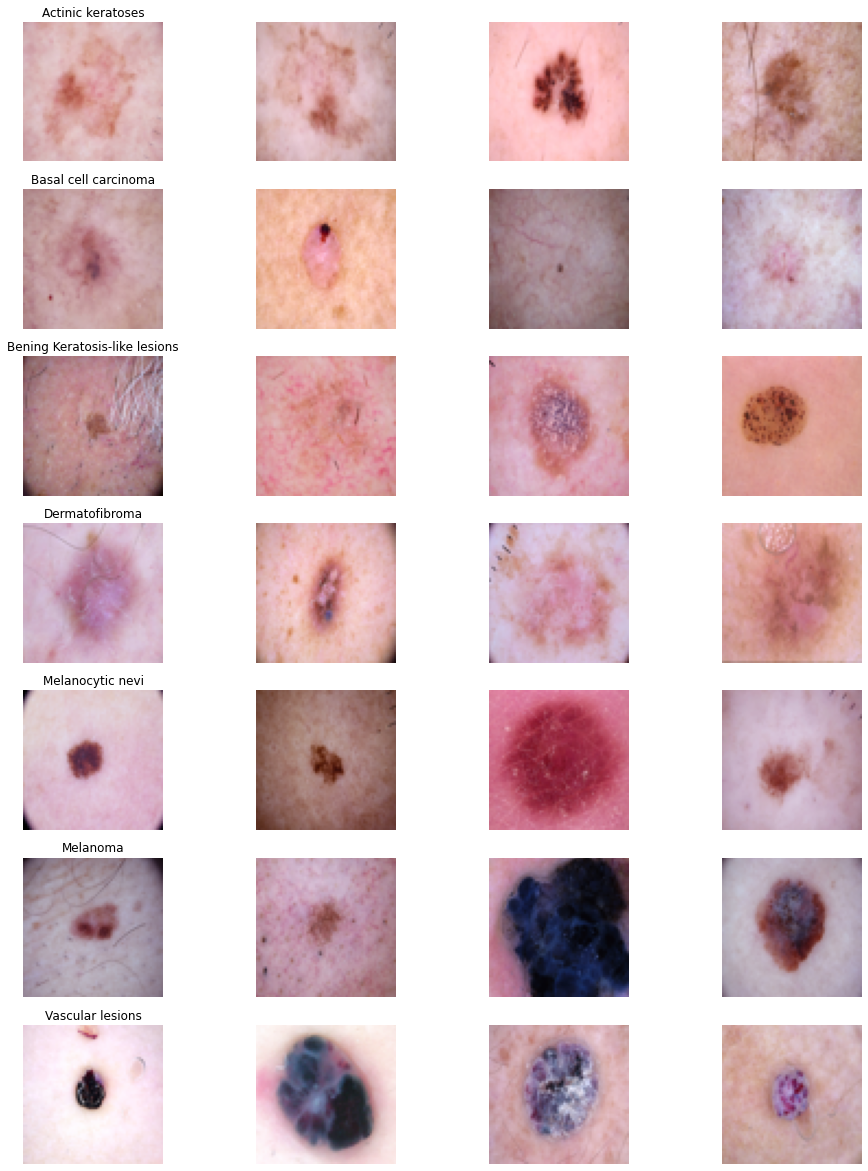

In [ ]:
fig, m_axs=plt.subplots(7,4, figsize=(4*4, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, dataset.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(str(type_name))
    for c_ax, (_,c_row) in zip(n_axs,type_rows.sample(7,random_state=17).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('categorical_samples.png',dpi=300)

Seleting the features and targets

In [ ]:
features=dataset.drop(columns=['cell_codes'],axis=1)
target=dataset['cell_codes']



Train test splitting

In [ ]:
x_train1,x_test1,y_train1,y_test1=train_test_split(features,target,test_size=0.27,random_state=42)

Normalising the training set

In [ ]:
x_train = np.asarray(x_train1['image'].tolist())
x_test= np.asarray(x_test1['image'].tolist())

x_train_mean=np.mean(x_train)
x_train_std=np.std(x_train)

x_test_mean=np.mean(x_test)
x_test_std=np.std(x_test)

x_train=(x_train - x_train_mean)/x_train_std
x_test=(x_test - x_test_mean)/x_test_std


Performing One-Hot Encoding on the labels

In [ ]:
y_train=to_categorical(y_train1 , num_classes=7)
y_test=to_categorical(y_test1, num_classes=7)


Validation and training set splitting

In [ ]:
x_train, x_validate, y_train,y_validate=train_test_split(x_train,y_train,test_size=0.117,random_state=42)

Reshaping image in 4 dimentions

In [ ]:
x_train= x_train.reshape(x_train.shape[0],*(64,64,3))
x_test= x_test.reshape(x_test.shape[0],*(64,64,3))
x_validate=x_validate.reshape(x_validate.shape[0],*(64,64,3))

Image Augumentation

In [ ]:
datagen=ImageDataGenerator(
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    rotation_range=37,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True


)
datagen.fit(x_train)

Class weights

In [ ]:
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train1),
                                        y = y_train1
                                    )


CNN

In [ ]:
shape = (64,64,3)

cnn_classifier=Sequential(name='cnn')

cnn_classifier.add(Conv2D(32,(3,3), activation='relu', input_shape=shape))
cnn_classifier.add(Conv2D(64,(3,3), activation='relu'))
cnn_classifier.add(MaxPool2D(pool_size=(2,2)))
cnn_classifier.add(Dropout(0.05))
cnn_classifier.add(Conv2D(128,(3,3), activation='relu'))

cnn_classifier.add(MaxPool2D(pool_size=(2,2)))
cnn_classifier.add(Dropout(0.10))
cnn_classifier.add(Conv2D(64,(3,3),activation='relu'))
cnn_classifier.add(Conv2D(128,(3,3), activation='relu'))
cnn_classifier.add(MaxPool2D(pool_size=(2,2)))
cnn_classifier.add(Dropout(0.10))

cnn_classifier.add(Flatten())

cnn_classifier.add(Dense(128,activation='relu', kernel_regularizer=regularizers.l2(0.00001)))
cnn_classifier.add(Dropout(0.15))
cnn_classifier.add(Dense(64,activation='relu',kernel_regularizer=regularizers.l2(0.00001)))
cnn_classifier.add(Dense(32,activation='relu',kernel_regularizer=regularizers.l2(0.00001)))
cnn_classifier.add(Dropout(0.20))
cnn_classifier.add(Dense(7,activation='softmax'))
cnn_classifier.summary()

Model: "cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 30, 30, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 128)      0         
 2D)                                                           

In [ ]:
previous_model = keras.models.load_model('cnn_classify_75_64.h5')

# copy weights from the previous model to the new one
for i, layer in enumerate(previous_model.layers):
    cnn_classifier.layers[i].set_weights(layer.get_weights())


Compiling the model

In [ ]:
from keras import optimizers
optm = optimizers.Adam(learning_rate=0.0007, beta_1=0.9, beta_2=0.999, amsgrad=False)
cnn_classifier.compile(optimizer=optm,loss='categorical_crossentropy', metrics=['accuracy'])
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.25, patience=2, verbose=1, min_lr=1e-5)
checkpoint = ModelCheckpoint('cnn_classify_100_64.h5', verbose=1,save_best_only=True)

Fitting the model

In [ ]:
epochs=100
batch_size=64

history=cnn_classifier.fit(datagen.flow(x_train,y_train,batch_size=batch_size),
                                    epochs=epochs, validation_data=(x_validate, y_validate),
                                    steps_per_epoch=x_train.shape[0]//batch_size,callbacks=[checkpoint])

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 0.2911 - accuracy: 0.9014
Epoch 1: val_loss improved from inf to 0.74920, saving model to cnn_classify_100_64.h5
100/100 [==============================] - 84s 828ms/step - loss: 0.2911 - accuracy: 0.9014 - val_loss: 0.7492 - val_accuracy: 0.7991
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.2572 - accuracy: 0.9070
Epoch 2: val_loss did not improve from 0.74920
100/100 [==============================] - 84s 840ms/step - loss: 0.2572 - accuracy: 0.9070 - val_loss: 0.7737 - val_accuracy: 0.7909
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.2689 - accuracy: 0.9089
Epoch 3: val_loss improved from 0.74920 to 0.72747, saving model to cnn_classify_100_64.h5
100/100 [==============================] - 84s 840ms/step - loss: 0.2689 - accuracy: 0.9089 - val_loss: 0.7275 - val_accuracy: 0.7932
Epoch 4/100
100/100 [==============================] - ETA: 0s - loss: 0.2641 - ac

Calculating validation set and test set accuracies

In [ ]:
loss, accuracy=cnn_classifier.evaluate(x_test,y_test)
loss_v,accuracy_v=cnn_classifier.evaluate(x_validate,y_validate)
print("Validation : accuracy=%f; loss=%f"%(accuracy_v,loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
#cnn_classifier.save("cnn_classify.h5")

27/27 [==============================] - 2s 69ms/step - loss: 0.8704 - accuracy: 0.8002
Validation : accuracy=0.800234; loss=0.870361
Test: accuracy = 0.781516  ;  loss = 1.091883


In [ ]:
plot_model(history, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
keras.models.save_model(cnn_classifier,'cnn_classify_100_64.h5')


Plotting Model's validation loss and validation accuracay

In [ ]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    #axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    #axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

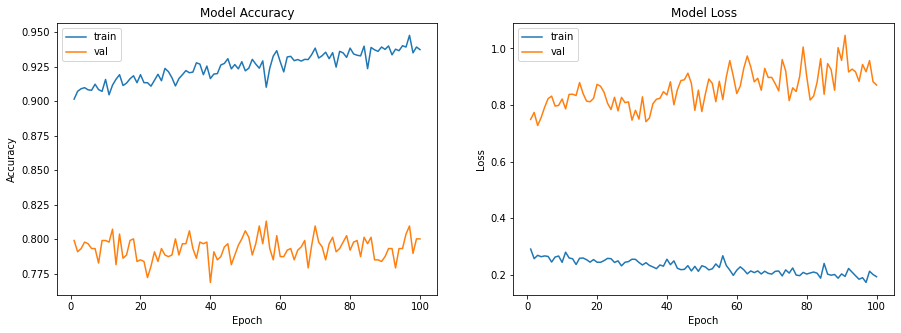

In [ ]:
plot_model_history(history)

Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks,classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]

    decoy=cm.max()/2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j , i , cm[i,j], horizontalalignment='center', color='white' if cm[i,j]>decoy else 'black')
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

In [ ]:
Y_pred = cnn_classifier.predict(x_validate)
Y_pred_classes=np.argmax(Y_pred, axis=1)
Y_true=np.argmax(y_validate, axis=1)
confusion_mtx=confusion_matrix(Y_true, Y_pred_classes)

plot_confusion_matrix(confusion_mtx, classes=range(7))

DenseNet

In [ ]:
def densenet(input_shape, n_classes, filters = 32):

    #batch norm + relu + conv
    def bn_rl_conv(x,filters,kernel=1,strides=1):

        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(filters, kernel, strides=strides,padding = 'same')(x)
        return x

    def dense_block(x, repetition):

        for _ in range(repetition):
            y = bn_rl_conv(x, 4*filters)
            y = bn_rl_conv(y, filters, 3)
            x = concatenate([y,x])
        return x

    def transition_layer(x):

        x = bn_rl_conv(x, K.int_shape(x)[-1] //2 )
        x = AvgPool2D(2, strides = 2, padding = 'same')(x)
        return x

    input = Input (input_shape)
    x = Conv2D(64, 7, strides = 2, padding = 'same')(input)
    x = MaxPool2D(3, strides = 2, padding = 'same')(x)

    for repetition in [6,12,24,16]:

        d = dense_block(x, repetition)
        x = transition_layer(d)
    x = GlobalAveragePooling2D()(d)
    x = BatchNormalization()(x)
    x = Dropout(0.15)(x)
    x = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.00001))(x)
    x = Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.00001))(x)

    output = Dense(n_classes, activation = 'softmax')(x)

    model = Model(input, output)
    return model


In [ ]:
'''input_shape = 64, 64, 3
n_classes = 7
# Load the pre-trained DenseNet model (without the top layer)
base_model = DenseNet121(weights='imagenet', include_top=False,input_shape=input_shape)

# Add a global average pooling layer and a dense output layer for the number of classes
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
input = Input (input_shape)

# Define the model by specifying the inputs and outputs
d_classifier = Model(inputs=base_model.input, outputs=predictions)

# Freeze the weights of the pre-trained layers to avoid overfitting on the small dataset
for layer in base_model.layers:
    layer.trainable = False'''

"input_shape = 64, 64, 3\nn_classes = 7\n# Load the pre-trained DenseNet model (without the top layer)\nbase_model = DenseNet121(weights='imagenet', include_top=False,input_shape=input_shape)\n\n# Add a global average pooling layer and a dense output layer for the number of classes\nx = base_model.output\nx = GlobalAveragePooling2D()(x)\npredictions = Dense(n_classes, activation='softmax')(x)\ninput = Input (input_shape)\n\n# Define the model by specifying the inputs and outputs\nd_classifier = Model(inputs=base_model.input, outputs=predictions)\n\n# Freeze the weights of the pre-trained layers to avoid overfitting on the small dataset\nfor layer in base_model.layers:\n    layer.trainable = False"

In [ ]:
input_shape = 64, 64, 3
n_classes = 7
d_classifier = densenet(input_shape,n_classes)
d_classifier.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_121 (Conv2D)            (None, 32, 32, 64)   9472        ['input_2[0][0]']                
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 16, 16, 64)  0           ['conv2d_121[0][0]']             
                                                                                                  
 batch_normalization_121 (Batch  (None, 16, 16, 64)  256         ['max_pooling2d_1[0][0]']        
 Normalization)                                                                             

In [ ]:
previous_model = keras.models.load_model('d_classify_25_64.h5')

# copy weights from the previous model to the new one
for i, layer in enumerate(previous_model.layers):
    d_classifier.layers[i].set_weights(layer.get_weights())


In [ ]:
optm = optimizers.Adam(learning_rate=0.0007, beta_1=0.9, beta_2=0.999, amsgrad=False)
d_classifier.compile(optimizer=optm,loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.25, patience=2, verbose=1, min_lr=1e-5)
checkpoint = ModelCheckpoint('d_classify_50_64.h5', verbose=1, save_best_only=True)

In [ ]:
epochs=50
batch_size=64

d_history=d_classifier.fit(datagen.flow(x_train,y_train,batch_size=batch_size),
                                    epochs=epochs, validation_data=(x_validate, y_validate),
                                    steps_per_epoch=x_train.shape[0]//batch_size,callbacks=[checkpoint] )


Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 0.7313 - accuracy: 0.7380
Epoch 1: val_loss improved from inf to 0.91036, saving model to d_classify_50_64.h5
100/100 [==============================] - 334s 3s/step - loss: 0.7313 - accuracy: 0.7380 - val_loss: 0.9104 - val_accuracy: 0.7044
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 0.8835 - accuracy: 0.7083
Epoch 2: val_loss did not improve from 0.91036
100/100 [==============================] - 312s 3s/step - loss: 0.8835 - accuracy: 0.7083 - val_loss: 6.3826 - val_accuracy: 0.7068
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 0.7822 - accuracy: 0.7213
Epoch 3: val_loss did not improve from 0.91036
100/100 [==============================] - 313s 3s/step - loss: 0.7822 - accuracy: 0.7213 - val_loss: 1.5269 - val_accuracy: 0.7173
Epoch 4/50
100/100 [==============================] - ETA: 0s - loss: 0.7062 - accuracy: 0.7430
Epoch 4: val_loss improved from 0.91036 to

In [ ]:
loss, accuracy=d_classifier.evaluate(x_test,y_test)
loss_v,accuracy_v=d_classifier.evaluate(x_validate,y_validate)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
print("Validation : accuracy=%f; loss=%f"%(accuracy_v,loss_v))

27/27 [==============================] - 12s 457ms/step - loss: 0.8980 - accuracy: 0.7944
Test: accuracy = 0.763771  ;  loss = 0.960024
Validation : accuracy=0.794393; loss=0.898025


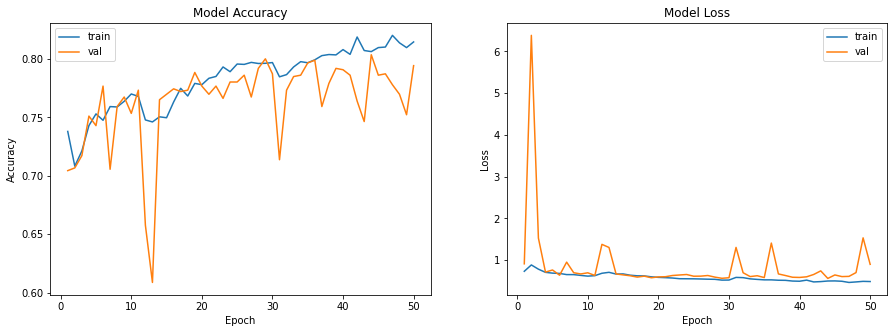

In [ ]:
plot_model_history(d_history)

In [ ]:
model=keras.models.save_model(d_classifier,'d_classify_50_64.h5')
#plot_model(model,to_file='d.png',show_shapes=True)

In [ ]:
Y_pred = d_classifier.predict(x_validate)
Y_pred_classes=np.argmax(Y_pred, axis=1)
Y_true=np.argmax(y_validate, axis=1)
confusion_mtx=confusion_matrix(Y_true, Y_pred_classes)

plot_confusion_matrix(confusion_mtx, classes=range(7))

RESNET-50

In [ ]:
def identity_block(X, f, filters, stage, block):

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

In [ ]:
def convolutional_block(X, f, filters, stage, block, s=2):

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
def ResNet50(input_shape,num_classes=7):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    X = Flatten()(X)
    X=Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(X)
    X=Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(X)
    X = Dense( num_classes,activation='softmax', name='fc3',kernel_initializer=glorot_uniform(seed=0))(X)
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

In [ ]:
input_shape=(64,64,3)
n_classes=7
r_classifier=ResNet50(input_shape,n_classes)
r_classifier.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 70, 70, 3)   0           ['input_3[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1 (Conv2D)                 (None, 32, 32, 64)   9472        ['zero_padding2d_2[0][0]']       
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1[0][0]']           

In [ ]:
previous_model = keras.models.load_model('r_classify_25_64.h5')

# copy weights from the previous model to the new one
for i, layer in enumerate(previous_model.layers):
    r_classifier.layers[i].set_weights(layer.get_weights())


In [ ]:
optm = optimizers.Adam(learning_rate=0.00000001, beta_1=0.9, beta_2=0.999, amsgrad=False)
r_classifier.compile(optimizer=optm,loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.12, patience=2, verbose=1, min_lr=1e-5)
checkpoint = ModelCheckpoint('r_classify_25_32.h5', verbose=1, save_best_only=True)

In [ ]:
epochs=25
batch_size=32

r_history=r_classifier.fit(datagen.flow(x_train,y_train,batch_size=batch_size),
                                    epochs=epochs, validation_data=(x_validate, y_validate),
                                    steps_per_epoch=x_train.shape[0]//batch_size,callbacks=[checkpoint,anne] )


Epoch 1/25
201/201 [==============================] - ETA: 0s - loss: 1.3632 - accuracy: 0.6661
Epoch 1: val_loss improved from inf to 1.03753, saving model to r_classify_25_32.h5
201/201 [==============================] - 501s 2s/step - loss: 1.3632 - accuracy: 0.6661 - val_loss: 1.0375 - val_accuracy: 0.6939 - lr: 1.0000e-08
Epoch 2/25
201/201 [==============================] - ETA: 0s - loss: 1.3485 - accuracy: 0.6666
Epoch 2: val_loss did not improve from 1.03753
201/201 [==============================] - 489s 2s/step - loss: 1.3485 - accuracy: 0.6666 - val_loss: 1.1854 - val_accuracy: 0.6939 - lr: 1.0000e-08
Epoch 3/25
201/201 [==============================] - ETA: 0s - loss: 1.3631 - accuracy: 0.6669
Epoch 3: val_loss did not improve from 1.03753
201/201 [==============================] - 420s 2s/step - loss: 1.3631 - accuracy: 0.6669 - val_loss: 1.3449 - val_accuracy: 0.6939 - lr: 1.0000e-08
Epoch 4/25
201/201 [==============================] - ETA: 0s - loss: 1.3703 - accuracy

In [ ]:
loss, accuracy=r_classifier.evaluate(x_test,y_test)
loss_v,accuracy_v=r_classifier.evaluate(x_validate,y_validate)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
print("Validation : accuracy=%f; loss=%f"%(accuracy_v,loss_v))

27/27 [==============================] - 8s 289ms/step - loss: 1.2817 - accuracy: 0.6939
Test: accuracy = 0.668022  ;  loss = 1.476030
Validation : accuracy=0.693925; loss=1.281653


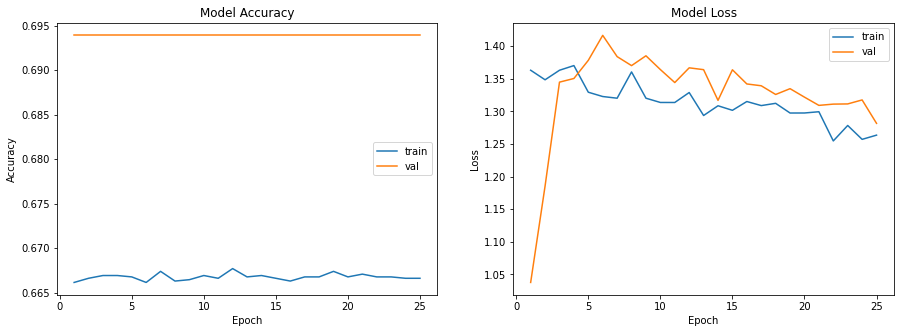

In [ ]:
plot_model_history(r_history)

In [ ]:
model=keras.models.save_model(d_classifier,'r_classify_50_64.h5')
#plot_model(model,to_file='d.png',show_shapes=True)

In [ ]:
Y_pred = r_classifier.predict(x_validate)
Y_pred_classes=np.argmax(Y_pred, axis=1)
Y_true=np.argmax(y_validate, axis=1)
confusion_mtx=confusion_matrix(Y_true, Y_pred_classes)

plot_confusion_matrix(confusion_mtx, classes=range(7))

Prediction

In [ ]:
classifier = keras.models.load_model('cnn_classify_150_32.h5')

In [ ]:
def pred(test_image,data):
    result = classifier.predict(test_image)

    if result[0][0] == 1:
        print('TYPE:-\t Actinic keratoses')
    elif result[0][1] == 1:
        print('TYPE:-\t Basal cell carcinoma')
    elif result[0][2] == 1:
        print('TYPE:-\t Benign keratosis-like lesions')
    elif result[0][3] == 1:
        print('TYPE:-\t Dermatofibroma')
    elif result[0][4] ==1 :
        print('TYPE:-\t Melanocytic nevi')
    elif result[0][5] == 1:
        print('TYPE:-\t Melanoma')
    elif result[0][6] == 1:
        print('TYPE:-\t Vascular lesions')

    print('Original Class: ',data['cell_type'].to_string())
    print("###################################################")

In [ ]:
for _ in range(5):
    data = dataset.sample()
    test_image=np.asarray(data['image'].to_list())


    test_image=test_image.reshape(test_image.shape[0],*(64,64,3))
    pred(test_image,data)


1/1 [==============================] - 1s 1s/step
TYPE:-	 Basal cell carcinoma
Original Class:  9725    Actinic keratoses
###################################################
1/1 [==============================] - 0s 61ms/step
TYPE:-	 Melanocytic nevi
Original Class:  4007    Melanocytic nevi
###################################################
1/1 [==============================] - 0s 94ms/step
TYPE:-	 Melanocytic nevi
Original Class:  3602    Melanocytic nevi
###################################################
1/1 [==============================] - 0s 104ms/step
TYPE:-	 Melanocytic nevi
Original Class:  9608    Melanocytic nevi
###################################################
1/1 [==============================] - 0s 71ms/step
TYPE:-	 Melanocytic nevi
Original Class:  9790    Actinic keratoses
###################################################
